# Imports

In [1]:
import os

import numpy as np
import pyro
from tqdm.auto import trange
import torch
import torch.distributions as td
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

np.random.seed(12345)
torch.manual_seed(12345)
tf.random.set_seed(12345)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda', index=1)

# MNIST data loading

Data will be stored under ./data/MNIST

In [3]:
os.makedirs("data", exist_ok=True)

In [4]:


def uniform_quantization(img):
    return (img*255+torch.rand(img.size()))/256

def rescale_logit(img,lambd=1e-6):
    ## logit space
    return torch.logit(lambd+(1-2*lambd)*img)



In [5]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        uniform_quantization,
        rescale_logit,
        torchvision.transforms.Lambda(lambd=torch.flatten)
    ]
)

mnist_train = torchvision.datasets.MNIST(root="data", download=True, transform=transform, train=True)
mnist_test = torchvision.datasets.MNIST(root="data", download=True, transform=transform, train=False)

Sanity check for the data:

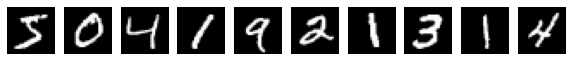

In [41]:
n_examples = 10
fig, axes = plt.subplots(nrows=1, ncols=n_examples, figsize=(n_examples, 1))

for i in range(n_examples):
    axes[i].imshow(mnist_train.data[i], cmap="gray")
    axes[i].axis('off')

plt.show()



In [7]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=1)

In [8]:
mnist_train.data[0].shape

torch.Size([28, 28])

Dimensionality of images:

In [9]:
d = 28
D = d ** 2

# Pyro RealNVP test

## NF construction

Latent distribution:

In [68]:
pyro_base_distribution = pyro.distributions.Normal(
    loc=torch.zeros((D,)).to(device),
    scale=torch.ones((D,)).to(device)
)

We are going to stack a few coupling blocks:

In [69]:
n_blocks = 5
blocks = []
for _ in range(n_blocks):
    blocks.append(
        pyro.distributions.transforms.affine_coupling(
            input_dim=D,
            hidden_dims=[D // 2, D // 2]
        ).to(device)
    )
    blocks.append(
        pyro.distributions.transforms.permute(
            input_dim=D,
            permutation=torch.from_numpy(np.random.permutation(D)).to(device)
        )
    )
    blocks.append(
        pyro.distributions.transforms.BatchNorm(
            input_dim=D
        ).to(device)
    )

In [70]:
pyro_transformed_distribution = pyro.distributions.TransformedDistribution(
    base_distribution=pyro_base_distribution,
    transforms=blocks
)

In [71]:
pyro_transformed_distribution.sample((2,)).shape

torch.Size([2, 784])

In [72]:
pyro_transformed_distribution.log_prob(torch.zeros((D,)).to(device))

tensor(6344.1436, device='cuda:1', grad_fn=<AddBackward0>)

## NF Training

In [73]:
modules = torch.nn.ModuleList([b for i, b in enumerate(blocks) if i%3 != 1])
optimizer = torch.optim.Adam(modules.parameters(),)# lr=1e-4, weight_decay=1e-5)
n_epochs = 7

In [74]:
pbar = trange(n_epochs)
losses = []
for epoch in pbar:
    for x_batch, _ in trainloader:
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        loss = - pyro_transformed_distribution.log_prob(x_batch).mean()
        loss.backward()
        optimizer.step()

        pyro_transformed_distribution.clear_cache()
        
        pbar.set_postfix_str(f"loss = {loss.item():.3f}")
    losses.append(loss)

In [67]:
losses

[tensor(1321.6934, device='cuda:1', grad_fn=<NegBackward>),
 tensor(1302.4893, device='cuda:1', grad_fn=<NegBackward>),
 tensor(1296.0135, device='cuda:1', grad_fn=<NegBackward>),
 tensor(1289.9678, device='cuda:1', grad_fn=<NegBackward>),
 tensor(1265.2670, device='cuda:1', grad_fn=<NegBackward>),
 tensor(1261.9404, device='cuda:1', grad_fn=<NegBackward>),
 tensor(1256.5835, device='cuda:1', grad_fn=<NegBackward>),
 tensor(1263.2568, device='cuda:1', grad_fn=<NegBackward>),
 tensor(9864.1016, device='cuda:1', grad_fn=<NegBackward>)]

## Generated examples

In [75]:
n_examples = 10
lambd = 1e-6
generated_images = (
    pyro_transformed_distribution
    .sample((n_examples,))
    .detach()
    .cpu()
)

generated_images = (torch.sigmoid(generated_images) - lambd) / (1 - 2 * lambd)

generated_images = (
    generated_images
    .view((n_examples, d, d))
    .numpy()
)

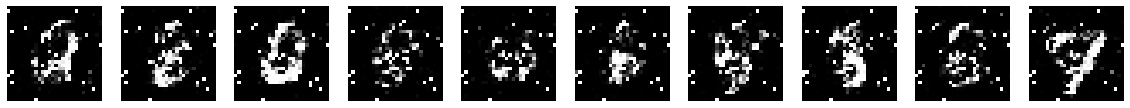

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=n_examples, figsize=(20, 40))

for i in range(n_examples):
    axes[i].imshow(generated_images[i], cmap="gray")
    axes[i].axis('off')

plt.show()

# TFP Glow test

## NF construction

Latent distribution:

In [ ]:
tf_base_distribution = tfd.Independent(
    tfd.Normal(
        loc=tf.zeros((d * d * 1,)),
        scale=1
    ),
    reinterpreted_batch_ndims=1
)

Glow model:

In [ ]:
glow = tfb.Glow(
    output_shape=(d, d, 1),
    num_glow_blocks=1,
    num_steps_per_block=8,
    coupling_bijector_fn=tfb.GlowDefaultNetwork,
    exit_bijector_fn=tfb.GlowDefaultExitNetwork
)

In [ ]:
tf_transformed_distribution = tfd.TransformedDistribution(
    tf_base_distribution,
    glow
)

## Training

In [ ]:
@tf.function
def train_step(
    optimizer,
    target_sample
):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(
            tf_transformed_distribution.log_prob(
                target_sample
            )
        )
    
    variables = glow.trainable_variables
    gradients = tape.gradient(
        loss,
        variables
    )

    optimizer.apply_gradients(
        zip(
            gradients,
            variables
        )
    )

    return loss

In [ ]:
# Training parameters
optimizer = tf.keras.optimizers.Adam()
n_epochs = 100

In [ ]:
pbar = trange(n_epochs)
for epoch in pbar:
    for x_batch, _ in trainloader:
        x_batch = x_batch.view(
            (-1, d, d, 1)
        ).numpy()

        loss = train_step(
            optimizer=optimizer,
            target_sample=x_batch
        )
        
    pbar.set_postfix_str(f"loss = {loss:.3f}")

## Generated Images

In [ ]:
n_examples = 3
generated_images = tf.reshape(
    tf_transformed_distribution.sample((n_examples,)),
    (n_examples, d, d)
)

In [ ]:
for i in range(n_examples):
    plt.imshow(generated_images[i], cmap="gray")
    plt.axis('off')
    plt.show()